# Causal Models for Specified Business Processes

This is an end-end pipeline for using causality in for business processes that are associated with a BPMN model.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import dowhy
from dowhy.do_why import CausalModel
import dowhy.datasets
import numpy as np
import networkx as nx
import xmltodict

import pandas as pd
from datetime import datetime
from tqdm import tqdm, tqdm_notebook

## Step 1 - Data Simulation

Given a BPMN model, we simulate logs for the business process using BIMP.

1. BIMP - http://bimp.cs.ut.ee/simulator
2. Save the MXML file generated

## Step 2 - Obtain Random Variables

Process the generated logs to obtain random variables of interest. The causal model will be built with these random variables.

In [4]:
# change this as required
mxml_filename = '../data/logs/A.1.v2.simulation_logs.mxml'
csv_filename = '../data/aggregates/A.1.v2.csv'
groupby_time_frequency = 'H'

In [3]:
# calculates aggregates
df = pd.DataFrame(columns=['case_id', 'activity', 'resource', 'complete_timestamp'])

with open(mxml_filename) as f:
    doc = xmltodict.parse(f.read())

for instance in tqdm(doc['WorkflowLog']['Process']['ProcessInstance']):
    case_id = instance['@id']
    resource = None
    iterator = instance['AuditTrailEntry']
    iterator.sort(key=lambda x: x['Timestamp'])
    for entry in iterator:
        if entry['EventType'] == 'assign':
            try:
                resource = entry['Originator']
            except KeyError:
                resource = None
            continue
        df = df.append({
            'case_id': case_id,
            'activity': entry['WorkflowModelElement'],
            'resource': resource,
            'complete_timestamp': entry['Timestamp']
        }, ignore_index=True)

df.head()

100%|██████████| 10000/10000 [06:59<00:00, 23.81it/s]


,case_id,activity,resource,complete_timestamp
0,2182,Start Event,None,2019-08-30T13:21:57.012+00:00
1,2182,Task 1,Resource 1,2019-08-30T14:10:18.445+00:00
2,2182,Task 2,Resource 2,2019-08-30T14:28:52.132+00:00
3,2182,Task 3,Resource 3,2019-08-30T15:10:33.004+00:00
4,2182,End Event,None,2019-08-30T15:10:33.004+00:00


In [5]:
df['completion_datetime'] = pd.to_datetime(df.complete_timestamp, format='%Y-%m-%dT%H:%M:%S.%f+00:00')
df.drop(columns='complete_timestamp', inplace=True)
df.fillna('None', inplace=True)

all_columns = ['timestamp'] + list(df['resource'].unique()) + list(df['activity'].unique())
data_aggregate = pd.DataFrame(columns=all_columns)

grouped = df.groupby(pd.Grouper(key='completion_datetime', freq=groupby_time_frequency))
for name1, group1 in grouped:
    temp_row = {key: 0 for key in all_columns}
    temp_row['timestamp'] = name1
    for name2, group2 in group1.groupby(['activity', 'resource']):
        count = len(group2['case_id'].unique())
        try:
            temp_row[name2[0]] += count
        except KeyError:
            pass
        try:
            temp_row[name2[1]] += count
        except KeyError:
            pass
    data_aggregate = data_aggregate.append(temp_row, ignore_index=True)

data_aggregate['hour'] = data_aggregate['timestamp'].apply(lambda x: x.hour)
data_aggregate.drop(columns=['timestamp', 'None'], inplace=True)
data_aggregate.head()

,Resource 1,Resource 2,Resource 3,Start Event,Task 1,Task 2,Task 3,End Event,hour
0,2,1,0,3,2,1,0,0,9
1,4,3,2,5,4,3,2,2,10
2,3,4,3,3,3,4,3,3,11
3,3,3,2,1,3,3,2,2,12
4,1,2,4,2,1,2,4,4,13


In [6]:
# data_aggregate = data_aggregate[data_aggregate['hour'] > 8]
# data_aggregate = data_aggregate[data_aggregate['hour'] <17]
data_aggregate.drop(columns=['hour'], inplace=True)
data_aggregate.head()

,Resource 1,Resource 2,Resource 3,Start Event,Task 1,Task 2,Task 3,End Event
0,2,1,0,3,2,1,0,0
1,4,3,2,5,4,3,2,2
2,3,4,3,3,3,4,3,3
3,3,3,2,1,3,3,2,2
4,1,2,4,2,1,2,4,4


In [7]:
data_aggregate.to_csv(csv_filename, index=False)

## Step 3 - Perform Structure Learning

In general, causal discovery is a hard problem. We use the BPMN model to guide causal discovery. 

This step is done in R.

```
library(bnlearn)

# edit input CSV filename
csv_filename <- "~/Documents/dev/bpm-causal/ipynb/new_aggregate.csv";

# read data
data <- read.csv(csv_filename);
# data[] <- lapply(data, as.factor)
data[] <- lapply(data, as.numeric)

# define blacklisted edges
partial_order = list(
  c("Start.Event"), 
  c("Task.1", "Resource.1"), 
  c("Task.2", "Resource.2"), 
  c("Task.3"), 
  c("End.Event"))
blacklist_edges <- tiers2blacklist(partial_order)

# add additional blacklisted edges
blacklist_edges <- rbind(blacklist_edges, c("Resource.1", "Resource.2"))
blacklist_edges <- rbind(blacklist_edges, c("Start.Event", "Resource.2"))

causal_model <- tabu(data, blacklist = blacklist_edges)

plot(causal_model)
print(causal_model["arcs"])
```

Copy paste the output.

In [12]:
# edit this according to R output
edges_list_str = """
[1,] "Resource.1"  "Task.1"   
[2,] "Resource.2"  "Task.2"   
[3,] "Resource.3"  "Task.3"   
[4,] "Start.Event" "Task.1"   
[5,] "Task.1"      "Task.2"   
[6,] "Task.2"      "Task.3"   
[7,] "Task.3"      "End.Event"          """

In [13]:
edges_list = []
for line in edges_list_str.split("\n"):
    line = line.strip().split(' ')
    line = list(filter(lambda x: len(x) > 0, line))
    if len(line) < 3:
        continue
    edges_list.append((line[1][1:-1], line[2][1:-1]))
edges_list = [(a.replace('.', ' '), b.replace('.', ' ')) for (a, b) in edges_list]
edges_list

[('Resource 1', 'Task 1'),
 ('Resource 2', 'Task 2'),
 ('Resource 3', 'Task 3'),
 ('Start Event', 'Task 1'),
 ('Task 1', 'Task 2'),
 ('Task 2', 'Task 3'),
 ('Task 3', 'End Event')]

## Step 4 - Causal Inference

Causal Inference has four steps - 
1. **Model** a causal inference problem using assumptions.
2. **Identify** an expression for the causal effect under these assumptions (“causal estimand”).
3. **Estimate** the expression using statistical methods such as matching or instrumental variables.
4. Finally, **verify validity** of the estimate using a variety of robustness checks.

In [366]:
# ideal edge list 
# edges_list = [('Start Event', "Task 1"),
#               ('Task 1', "Task 2"),
#               ('Task 2', "Task 3"),
#               ('Task 3', "End Event"),
#               ('Resource 1', 'Task 1'),
#               ('Resource 2', 'Task 2'),
#               ('Resource 3', 'Task 3')]

In [14]:
lucas_graph = nx.DiGraph()
lucas_graph.add_edges_from(edges_list)

# nx.draw_circular(lucas_graph, with_labels=True, font_weight='bold')

### Visualize the model

Model to find the causal effect of treatment Resource 1 on outcome Task 3


/Users/tanmayee/anaconda/envs/py36/lib/python3.6/site-packages/pygraphviz/agraph.py:1341: RuntimeWarning: Warning: Could not load "/Users/tanmayee/anaconda/envs/py36/lib/graphviz/libgvplugin_pango.6.dylib" - file not found

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


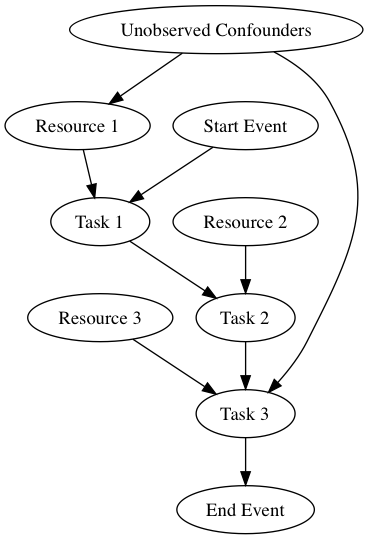

In [16]:
lucas_graph_str = ''.join(list(nx.generate_gml(lucas_graph)))

lucas_model = CausalModel(
                data = data_aggregate,
                treatment="Resource 1",
                outcome="Task 3",
                graph=lucas_graph_str
                )
lucas_model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

------
## Structural Causal Model Framework

In the initial simulation, `Resource_1` performs `Task 1` in $\mathcal{N}(20, 15)$, which is $3$ tasks per hour on average.

What if `Resource 1` was optimised to perform $6$ tasks per hour instead?

In [17]:
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split

In [18]:
scm_function_list = {}
for node in lucas_graph.nodes():
    parents = list(lucas_graph.predecessors(node))
    if len(parents) == 0:
        continue
    X = data_aggregate[list(lucas_graph.predecessors(node))]
    Y = data_aggregate[node]
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y)
    
    # try linear regression, lasso and ridge
    _linear = LinearRegression().fit(X_train, Y_train)
    _lasso = Lasso().fit(X_train, Y_train)
    _ridge = Ridge().fit(X_train, Y_train)
    _svr = SVR(epsilon=0.05).fit(X_train, Y_train)
    
    print(_svr.score(X_test, Y_test))
    
    _linear_score, _lasso_score, _ridge_score = _linear.score(X_test, Y_test), _lasso.score(X_test, Y_test), _ridge.score(X_test, Y_test)
    print(_linear_score, _lasso_score, _ridge_score)
    
    if max([_linear_score, _lasso_score, _ridge_score]) == _linear_score:
        print("{0}\tLinear\t{1}".format(node, _linear_score))
        scm_function_list[node] = {'model': _linear,
                              'parents': list(lucas_graph.predecessors(node))}
    elif max([_linear_score, _lasso_score, _ridge_score]) == _lasso_score:
        print("{0}\tLasso\t{1}".format(node, _lasso_score))
        scm_function_list[node] = {'model': _lasso,
                              'parents': list(lucas_graph.predecessors(node))}
    else:
        print("{0}\tRidge\t{1}".format(node, _ridge_score))
        scm_function_list[node] = {'model': _ridge,
                              'parents': list(lucas_graph.predecessors(node))}

0.9970116729843364
1.0 -5.772117060787174e-05 0.9999999841226589
Task 1	Linear	1.0
0.9971708870345319
1.0 -0.00015065983927531335 0.9999999709232512
Task 2	Linear	1.0
0.9966865984576468
1.0 -3.5881926244929474e-05 0.9999999800461216
Task 3	Linear	1.0
0.9968767076990671
1.0 -0.0018681788435699342 0.9999999944339701
End Event	Linear	1.0


In [19]:
scm_function_list

{'End Event': {'model': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
  'parents': ['Task 3']},
 'Task 1': {'model': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
  'parents': ['Resource 1', 'Start Event']},
 'Task 2': {'model': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
  'parents': ['Resource 2', 'Task 1']},
 'Task 3': {'model': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
  'parents': ['Resource 3', 'Task 2']}}

---

In [70]:
# intervene on start_event
start_event = 6 

X = np.array([np.mean(data_aggregate['Resource 1']), start_event]).reshape((1, -1))
task_1 = scm_function_list['Task 1']['model'].predict(X)
task_1

X = np.array([np.mean(data_aggregate['Resource 2']),
              task_1])
X = X.reshape((1, -1))
task_2 = scm_function_list['Task 2']['model'].predict(X)
task_2

X = np.array([np.mean(data_aggregate['Resource 3']),
             task_2])
X = X.reshape((1, -1))
task_3 = scm_function_list['Task 3']['model'].predict(X)
task_3

X = np.array([ task_3])
X = X.reshape((1, -1))
end_event = scm_function_list['End Event']['model'].predict(X)
end_event

print(start_event, task_1, task_2, task_3, end_event)

6 [0.47553379] [0.47553379] [0.47553379] [0.47553379]


In [67]:
# change this as required
mxml_filename = '../data/logs/A.1.v2.2.intervention_simulation_logs'
groupby_time_frequency = 'H'

# calculates aggregates
df = pd.DataFrame(columns=['case_id', 'activity', 'resource', 'complete_timestamp'])

with open(mxml_filename) as f:
    doc = xmltodict.parse(f.read())

for instance in tqdm(doc['WorkflowLog']['Process']['ProcessInstance']):
    case_id = instance['@id']
    resource = None
    iterator = instance['AuditTrailEntry']
    iterator.sort(key=lambda x: x['Timestamp'])
    for entry in iterator:
        if entry['EventType'] == 'assign':
            try:
                resource = entry['Originator']
            except KeyError:
                resource = None
            continue
        df = df.append({
            'case_id': case_id,
            'activity': entry['WorkflowModelElement'],
            'resource': resource,
            'complete_timestamp': entry['Timestamp']
        }, ignore_index=True)

df.head()

100%|██████████| 10000/10000 [07:23<00:00, 22.53it/s]


,case_id,activity,resource,complete_timestamp
0,2182,Start Event,None,2019-04-25T12:40:00.000+00:00
1,2182,Task 1,Resource 1,2019-04-25T17:03:29.248+00:00
2,2182,Task 2,Resource 2,2019-04-25T17:30:05.304+00:00
3,2182,Task 3,Resource 3,2019-04-25T18:04:06.421+00:00
4,2182,End Event,None,2019-04-25T18:04:06.421+00:00


In [69]:
df['completion_datetime'] = pd.to_datetime(df.complete_timestamp, format='%Y-%m-%dT%H:%M:%S.%f+00:00')
df.drop(columns='complete_timestamp', inplace=True)
df.fillna('None', inplace=True)
    
all_columns = ['timestamp'] + list(df['resource'].unique()) + list(df['activity'].unique())
inter_data_aggregate = pd.DataFrame(columns=all_columns)

grouped = df.groupby(pd.Grouper(key='completion_datetime', freq=groupby_time_frequency))
for name1, group1 in tqdm(grouped):
    temp_row = {key: 0 for key in all_columns}
    temp_row['timestamp'] = name1
    for name2, group2 in group1.groupby(['activity', 'resource']):
        count = len(group2['case_id'].unique())
        try:
            temp_row[name2[0]] += count
        except KeyError:
            pass
        try:
            temp_row[name2[1]] += count
        except KeyError:
            pass
    inter_data_aggregate = inter_data_aggregate.append(temp_row, ignore_index=True)

inter_data_aggregate['hour'] = inter_data_aggregate['timestamp'].apply(lambda x: x.hour)
inter_data_aggregate.drop(columns=['timestamp', 'None'], inplace=True)
inter_data_aggregate.head()

100%|██████████| 7014/7014 [00:36<00:00, 194.27it/s]


,Resource 1,Resource 2,Resource 3,Start Event,Task 1,Task 2,Task 3,End Event,hour
0,3,1,1,6,3,1,1,1,9
1,3,4,2,6,3,4,2,2,10
2,2,2,2,6,2,2,2,2,11
3,3,4,3,6,3,4,3,3,12
4,5,3,2,6,5,3,2,2,13


In [74]:
inter_data_aggregate.mean()

Resource 1      1.42572
Resource 2      1.42572
Resource 3      1.42572
Start Event     1.42572
Task 1          1.42572
Task 2          1.42572
Task 3          1.42572
End Event       1.42572
hour           11.50000
dtype: float64

----

In [75]:
data_aggregate['Resource 2'].value_counts()

0    15707
2     2217
1     1948
3     1013
4      141
5        3
Name: Resource 2, dtype: int64

In [78]:
# intervene on resource_2
resource_2 = 3

X = np.array([np.mean(data_aggregate['Resource 1']), np.mean(data_aggregate['Start Event'])]).reshape((1, -1))
task_1 = scm_function_list['Task 1']['model'].predict(X)
task_1

X = np.array([resource_2,
              task_1])
X = X.reshape((1, -1))
task_2 = scm_function_list['Task 2']['model'].predict(X)
task_2

X = np.array([np.mean(data_aggregate['Resource 3']),
             task_2])
X = X.reshape((1, -1))
task_3 = scm_function_list['Task 3']['model'].predict(X)
task_3

X = np.array([ task_3])
X = X.reshape((1, -1))
end_event = scm_function_list['End Event']['model'].predict(X)
end_event

print(task_1, task_2, task_3, end_event)

[0.47553379] [3.] [0.47553379] [0.47553379]


In [79]:
# change this as required
mxml_filename = '../data/logs/A.1.v2.3.intervention_simulation_logs'
groupby_time_frequency = 'H'

# calculates aggregates
df = pd.DataFrame(columns=['case_id', 'activity', 'resource', 'complete_timestamp'])

with open(mxml_filename) as f:
    doc = xmltodict.parse(f.read())

for instance in tqdm(doc['WorkflowLog']['Process']['ProcessInstance']):
    case_id = instance['@id']
    resource = None
    iterator = instance['AuditTrailEntry']
    iterator.sort(key=lambda x: x['Timestamp'])
    for entry in iterator:
        if entry['EventType'] == 'assign':
            try:
                resource = entry['Originator']
            except KeyError:
                resource = None
            continue
        df = df.append({
            'case_id': case_id,
            'activity': entry['WorkflowModelElement'],
            'resource': resource,
            'complete_timestamp': entry['Timestamp']
        }, ignore_index=True)

df.head()

100%|██████████| 10000/10000 [07:36<00:00, 21.89it/s]


,case_id,activity,resource,complete_timestamp
0,2182,Start Event,None,2019-09-02T13:13:29.584+00:00
1,2182,Task 1,Resource 1,2019-09-02T13:58:05.657+00:00
2,2182,Task 2,Resource 2,2019-09-02T14:19:34.873+00:00
3,2182,Task 3,Resource 3,2019-09-02T14:46:57.365+00:00
4,2182,End Event,None,2019-09-02T14:46:57.365+00:00


In [80]:
df['completion_datetime'] = pd.to_datetime(df.complete_timestamp, format='%Y-%m-%dT%H:%M:%S.%f+00:00')
df.drop(columns='complete_timestamp', inplace=True)
df.fillna('None', inplace=True)
    
all_columns = ['timestamp'] + list(df['resource'].unique()) + list(df['activity'].unique())
inter_data_aggregate = pd.DataFrame(columns=all_columns)

grouped = df.groupby(pd.Grouper(key='completion_datetime', freq=groupby_time_frequency))
for name1, group1 in tqdm(grouped):
    temp_row = {key: 0 for key in all_columns}
    temp_row['timestamp'] = name1
    for name2, group2 in group1.groupby(['activity', 'resource']):
        count = len(group2['case_id'].unique())
        try:
            temp_row[name2[0]] += count
        except KeyError:
            pass
        try:
            temp_row[name2[1]] += count
        except KeyError:
            pass
    inter_data_aggregate = inter_data_aggregate.append(temp_row, ignore_index=True)

inter_data_aggregate['hour'] = inter_data_aggregate['timestamp'].apply(lambda x: x.hour)
inter_data_aggregate.drop(columns=['timestamp', 'None'], inplace=True)
inter_data_aggregate.head()

100%|██████████| 21009/21009 [02:27<00:00, 142.47it/s]


,Resource 1,Resource 2,Resource 3,Start Event,Task 1,Task 2,Task 3,End Event,hour
0,2,1,0,4,2,1,0,0,9
1,3,3,3,1,3,3,3,3,10
2,2,2,2,3,2,2,2,2,11
3,1,2,2,1,1,2,2,2,12
4,2,2,3,2,2,2,3,3,13


In [82]:
inter_data_aggregate.mean()

Resource 1      0.475986
Resource 2      0.475986
Resource 3      0.475986
Start Event     0.475986
Task 1          0.475986
Task 2          0.475986
Task 3          0.475986
End Event       0.475986
hour           11.500643
dtype: float64

----

In [84]:
data_aggregate['Resource 3'].value_counts()

0    15781
2     2368
1     1766
3      969
4      134
5       11
Name: Resource 3, dtype: int64

In [89]:
# intervene on resource_3
resource_3 = 1

X = np.array([np.mean(data_aggregate['Resource 1']), np.mean(data_aggregate['Start Event'])]).reshape((1, -1))
task_1 = scm_function_list['Task 1']['model'].predict(X)
task_1

X = np.array([np.mean(data_aggregate['Resource 2']),
              task_1])
X = X.reshape((1, -1))
task_2 = scm_function_list['Task 2']['model'].predict(X)
task_2

X = np.array([resource_3,
             task_2])
X = X.reshape((1, -1))
task_3 = scm_function_list['Task 3']['model'].predict(X)
task_3

X = np.array([ task_3])
X = X.reshape((1, -1))
end_event = scm_function_list['End Event']['model'].predict(X)
end_event

print(task_1, task_2, task_3, end_event)

[0.47553379] [0.47553379] [1.] [1.]


In [90]:
# change this as required
mxml_filename = '../data/logs/A.1.v2.5.intervention_simulation_logs'
groupby_time_frequency = 'H'

# calculates aggregates
df = pd.DataFrame(columns=['case_id', 'activity', 'resource', 'complete_timestamp'])

with open(mxml_filename) as f:
    doc = xmltodict.parse(f.read())

for instance in tqdm(doc['WorkflowLog']['Process']['ProcessInstance']):
    case_id = instance['@id']
    resource = None
    iterator = instance['AuditTrailEntry']
    iterator.sort(key=lambda x: x['Timestamp'])
    for entry in iterator:
        if entry['EventType'] == 'assign':
            try:
                resource = entry['Originator']
            except KeyError:
                resource = None
            continue
        df = df.append({
            'case_id': case_id,
            'activity': entry['WorkflowModelElement'],
            'resource': resource,
            'complete_timestamp': entry['Timestamp']
        }, ignore_index=True)

df.head()

100%|██████████| 10000/10000 [07:56<00:00, 20.98it/s]


,case_id,activity,resource,complete_timestamp
0,2182,Start Event,None,2019-08-30T12:58:25.453+00:00
1,2182,Task 1,Resource 1,2019-08-30T13:44:29.969+00:00
2,2182,Task 2,Resource 2,2019-08-30T13:59:43.105+00:00
3,2182,Task 3,Resource 3,2019-08-30T20:37:55.184+00:00
4,2182,End Event,None,2019-08-30T20:37:55.184+00:00


In [91]:
df['completion_datetime'] = pd.to_datetime(df.complete_timestamp, format='%Y-%m-%dT%H:%M:%S.%f+00:00')
df.drop(columns='complete_timestamp', inplace=True)
df.fillna('None', inplace=True)
    
all_columns = ['timestamp'] + list(df['resource'].unique()) + list(df['activity'].unique())
inter_data_aggregate = pd.DataFrame(columns=all_columns)

grouped = df.groupby(pd.Grouper(key='completion_datetime', freq=groupby_time_frequency))
for name1, group1 in tqdm(grouped):
    temp_row = {key: 0 for key in all_columns}
    temp_row['timestamp'] = name1
    for name2, group2 in group1.groupby(['activity', 'resource']):
        count = len(group2['case_id'].unique())
        try:
            temp_row[name2[0]] += count
        except KeyError:
            pass
        try:
            temp_row[name2[1]] += count
        except KeyError:
            pass
    inter_data_aggregate = inter_data_aggregate.append(temp_row, ignore_index=True)

inter_data_aggregate['hour'] = inter_data_aggregate['timestamp'].apply(lambda x: x.hour)
inter_data_aggregate.drop(columns=['timestamp', 'None'], inplace=True)
inter_data_aggregate.head()

100%|██████████| 20861/20861 [02:41<00:00, 129.01it/s]


,Resource 1,Resource 2,Resource 3,Start Event,Task 1,Task 2,Task 3,End Event,hour
0,1,1,0,2,1,1,0,0,9
1,3,2,1,2,3,2,1,1,10
2,1,2,1,2,1,2,1,1,11
3,2,1,1,2,2,1,1,1,12
4,2,3,1,1,2,3,1,1,13


In [92]:
inter_data_aggregatea_aggregatea_aggregate_data_aggregate.mean()

NameError: name 'inter_data_aggregatea_aggregatea_aggregate_data_aggregate' is not defined

----

In [64]:
# intervene on resource_1
resource_1 = 4

X = np.array([resource_1, np.mean(data_aggregate['Start Event'])]).reshape((1, -1))
task_1 = scm_function_list['Task 1']['model'].predict(X)
task_1

X = np.array([np.mean(data_aggregate['Resource 2']),
              task_1])
X = X.reshape((1, -1))
task_2 = scm_function_list['Task 2']['model'].predict(X)
task_2

X = np.array([np.mean(data_aggregate['Resource 3']),
             task_2])
X = X.reshape((1, -1))
task_3 = scm_function_list['Task 3']['model'].predict(X)
task_3

X = np.array([ task_3])
X = X.reshape((1, -1))
end_event = scm_function_list['End Event']['model'].predict(X)
end_event

print(task_1, task_2, task_3, end_event)

[4.] [0.47553379] [0.47553379] [0.47553379]


### Checking if estimate meets simulation data

In [40]:
# inter_data_aggregate = inter_data_aggregate[inter_data_aggregate['hour'] > 8]
# inter_data_aggregate = inter_data_aggregate[inter_data_aggregate['hour'] <17]
inter_data_aggregate.head()
np.mean(inter_data_aggregate['Task 2'])

In [41]:
inter_data_aggregate.mean()

Resource 1      0.475534
Resource 2      0.475534
Resource 3      0.475534
Start Event     0.475534
Task 1          0.475534
Task 2          0.475534
Task 3          0.475534
End Event       0.475534
hour           11.499881
dtype: float64

In [42]:
data_aggregate.mean()

Resource 1     0.475534
Resource 2     0.475534
Resource 3     0.475534
Start Event    0.475534
Task 1         0.475534
Task 2         0.475534
Task 3         0.475534
End Event      0.475534
dtype: float64